
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [38]:
## library imports here
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from palmerpenguins import load_penguins
import numpy as np
from palmerpenguins import load_penguins
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures,label_binarize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, accuracy_score, classification_report, roc_curve, auc,roc_auc_score
import plotnine as pt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

In [39]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [11]:
X = ha.drop(columns=['cp'])
y = ha['cp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

ct = ColumnTransformer(
  [  
    ("standardize", StandardScaler(), ["age","trtbps","chol", "thalach"]),
    ("dummify", OneHotEncoder(sparse_output = False), ["sex", "restecg", "output"])
  ],
  remainder = "drop"
)

knn_pipeline1 = Pipeline(
    [
        ("preprocessing", ct),
        ("knn", KNeighborsClassifier())
    ]
).set_output(transform="pandas")

params = {'knn__n_neighbors': list(range(1, 50))}

grid_search = GridSearchCV(
    knn_pipeline1,
    params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_n_neighbors = grid_search.best_params_['knn__n_neighbors']
best_accuracy = grid_search.best_score_

print(f"Best n_neighbors: {best_n_neighbors}")
print(f"Best Accuracy: {best_accuracy}")


Best n_neighbors: 39
Best Accuracy: 0.5654520917678811


In [ ]:
tree_pipeline = Pipeline([
    ("preprocessing", ct),  # Include preprocessing step
    ('tree', DecisionTreeClassifier(random_state=42))  # Tree model
])

# Parameter grid for GridSearchCV
tree_param_grid = {
    'tree__max_depth': range(1, 30),  
    'tree__criterion': ['gini', 'entropy'], 
    'tree__min_samples_split': [2, 5, 10] 
}

# Perform GridSearchCV
tree_grid_search = GridSearchCV(
    tree_pipeline,
    param_grid=tree_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search on training data
tree_grid_search.fit(X_train, y_train)

# Extract the best parameters and accuracy
best_tree_params = tree_grid_search.best_params_
best_accuracy = tree_grid_search.best_score_

# Display the best max depth
best_max_depth = best_tree_params['tree__max_depth']
print(f"Best Decision Tree Parameters: {best_tree_params}")
print(f"Best Max Depth: {best_max_depth}")
print(f"Best Accuracy: {best_accuracy:.2f}")

# Use the best model to make predictions
best_tree_model = tree_grid_search.best_estimator_
y_pred_tree = best_tree_model.predict(X_test)

# Evaluate the final model
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_tree))

Best Decision Tree Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__min_samples_split': 2}
Best Max Depth: 1
Best Accuracy: 0.57
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.79      0.75        39
           1       0.00      0.00      0.00        13
           2       0.45      0.71      0.55        24
           3       0.00      0.00      0.00         6

    accuracy                           0.59        82
   macro avg       0.29      0.38      0.32        82
weighted avg       0.47      0.59      0.52        82



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


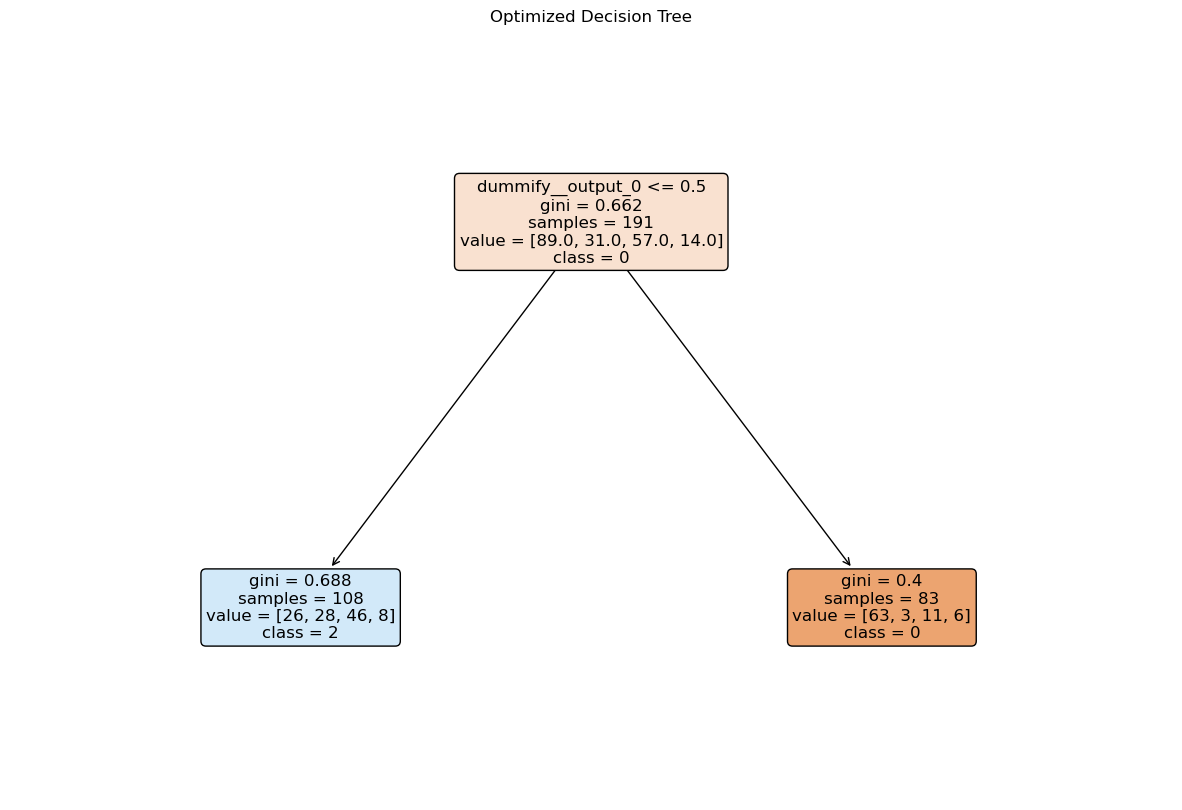

In [24]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Retrieve the best decision tree model from grid search
best_tree_model = tree_grid_search.best_estimator_

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(best_tree_model.named_steps['tree'], 
          feature_names=ct.get_feature_names_out(),  # Get feature names after transformation
          class_names=['0', '1', '2', '3'],  # Assuming 4 classes for chest pain type
          filled=True,  # Color the nodes based on the class they predict
          rounded=True,  # Round the corners for better readability
          fontsize=12)  # Set font size for better readability
plt.title("Optimized Decision Tree")
plt.show()

For this decsion tree, we only have one split. This splits based on age with older people being more prone to chest pain.

In [ ]:
# LDA Pipeline
lda_pipeline = Pipeline([
    ("preprocessing", ct),  
    ('lda', LinearDiscriminantAnalysis())  
])

lda_param_grid = {
    'lda__solver': ['svd', 'lsqr', 'eigen']  
}

lda_grid_search = GridSearchCV(
    lda_pipeline,
    param_grid=lda_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search
lda_grid_search.fit(X_train, y_train)

# Access the best parameters
best_lda_params = lda_grid_search.best_params_ 
best_solver = best_lda_params['lda__solver']  
best_accuracy = lda_grid_search.best_score_

print(f"Best Decision Tree Parameters: {best_tree_params}")
print(f"Best Max Depth: {best_solver}")
print(f"Best Accuracy: {best_accuracy:.2f}")


# LDA
lda_pipeline.fit(X_train, y_train)
y_pred_lda = lda_pipeline.predict(X_test)
print("LDA Classification Report:\n", classification_report(y_test, y_pred_lda))

Best Decision Tree Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__min_samples_split': 2}
Best Max Depth: svd
Best Accuracy: 0.52
LDA Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.79      0.75        39
           1       0.20      0.23      0.21        13
           2       0.45      0.42      0.43        24
           3       0.00      0.00      0.00         6

    accuracy                           0.54        82
   macro avg       0.34      0.36      0.35        82
weighted avg       0.50      0.54      0.52        82



/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.f

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [42]:
ha[f'cp_is_0'] = (ha['cp'] == 0).astype(int)
ha[f'cp_is_1'] = (ha['cp'] == 1).astype(int)
ha[f'cp_is_2'] = (ha['cp'] == 2).astype(int)
ha[f'cp_is_3'] = (ha['cp'] == 3).astype(int)

X = ha.drop(columns=['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'])
y_columns = ['cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

ha.head()


,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_0,cp_is_1,cp_is_2,cp_is_3
0,63,1,3,145,233,0,150,1,0,0,0,1
1,37,1,2,130,250,1,187,1,0,0,1,0
2,56,1,1,120,236,1,178,1,0,1,0,0
3,57,0,0,120,354,1,163,1,1,0,0,0
4,57,1,0,140,192,1,148,1,1,0,0,0


In [36]:
from sklearn.metrics import f1_score
f1_scores = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for target_col in y_columns:
    y = ha[target_col]  # Select the binary target column

    # Create pipeline with preprocessing and logistic regression
    pipeline = Pipeline([
        ('preprocessing', ct),
        ('logreg', LogisticRegression(max_iter=1000, solver='lbfgs'))
    ])
    
    f1_scorer = make_scorer(f1_score)
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring=f1_scorer, n_jobs=-1)
    
    # Store average F1 score for this target column
    f1_scores[target_col] = np.mean(scores)

    # Fit the model
    # pipeline.fit(X_train, y_train)
    
    # # Predict and compute F1 score
    # y_pred = pipeline.predict(X_test)
    # f1 = f1_score(y_test, y_pred)
    # f1_scores[target_col] = f1

# Report the F1 scores for each category
for category, f1 in f1_scores.items():
    print(f"F1 Score for OvR with {category}: {f1:.4f}")

# Determine the category with the best F1 score
best_category = max(f1_scores, key=f1_scores.get)
print(f"\nBest OvR approach at distinguishing category: {best_category}")

F1 Score for OvR with cp_is_0: 0.7202
F1 Score for OvR with cp_is_1: 0.0000
F1 Score for OvR with cp_is_2: 0.1188
F1 Score for OvR with cp_is_3: 0.0000

Best OvR approach at distinguishing category: cp_is_0


The best OvR model was the one for a chest pain score of 0. It gave me a F1 score of 0.72 which was far higher than the other F1 scores for the other categories. This means it was a far more accurate predictor than all the rest.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [63]:
ha01 = ha[(ha['cp'] == 0) | (ha['cp'] == 1)]
ha01.head()

X = ha01.drop(columns=['cp','cp_is_0','cp_is_1','cp_is_2','cp_is_3'])
y = ha01['cp']

In [64]:
ovopipeline = Pipeline([
    ('preprocessing', ct),
    ('logreg', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(ovopipeline, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)


# Output the ROC-AUC score
print(f"ROC-AUC Score for OvO between cp 0 and cp 1:", scores.mean())

ROC-AUC Score for OvO between cp 0 and cp 1: 0.8226495726495726


In [57]:
ha02 = ha[(ha['cp'] == 0) | (ha['cp'] == 2)]
ha01.head()

X = ha02.drop(columns=['cp','cp_is_0','cp_is_1','cp_is_2','cp_is_3'])
y = ha02['cp']



In [62]:
ovopipeline = Pipeline([
    ('preprocessing', ct),
    ('logreg', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# Define StratifiedKFold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use cross_val_score for ROC-AUC scoring
roc_auc_scores = cross_val_score(ovopipeline, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)

# Output the average ROC-AUC score
print(f"Average ROC-AUC Score for OvO between cp 0 and cp 2: {roc_auc_scores.mean():.4f}")

Average ROC-AUC Score for OvO between cp 0 and cp 2: 0.7410


In [69]:
ha03 = ha[(ha['cp'] == 0) | (ha['cp'] == 3)]
ha03.head()

X = ha03.drop(columns=['cp','cp_is_0','cp_is_1','cp_is_2','cp_is_3'])
y = ha03['cp']



In [70]:
ovopipeline = Pipeline([
    ('preprocessing', ct),
    ('logreg', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# Define StratifiedKFold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use cross_val_score for ROC-AUC scoring
roc_auc_scores = cross_val_score(ovopipeline, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)

# Output the average ROC-AUC score
print(f"Average ROC-AUC Score for OvO between cp 0 and cp 2: {roc_auc_scores.mean():.4f}")

Average ROC-AUC Score for OvO between cp 0 and cp 2: 0.7278


This shows us that the highest ROC AUC value for a chest pain rating of 0 was when it was compared to a chest pain rating of 1, followed by 2, with a cp rating of 3 being the lowest AUC value. This means the model had the best predictions when determining the difference between a chest pain rating of 0 and a chest pain rating of 1. The ROC AUC value was 0.82 which far exceeds the baseline model of 0.5.

Chat GPT 4o was used to automate some pipeline processes as well as debugging errors. 